In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

from utils import cargar_dataset, agrupar, generar_random_walk, generar_ruido_blanco


In [50]:
# 1. Cargar datos
df = cargar_dataset()
df = df[df["timestamp"] < pd.Timestamp("2026-01-15")]

df.head()

,id,timestamp,provincia,titulo,sentimiento,Hostelería y Turismo,Sanitario y Salud,Educación y Formación,Tecnología y Telecomunicaciones,Construcción e Inmobiliaria,...,Administración y Finanzas,"Cultura, Arte y Ocio",topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
0,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Asturias,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),0,0.041404,0.120992,0.041573,0.059019,0.030701,...,0.324229,0.019733,0.026325,0.026326,0.814183,0.026330,0.027860,0.026326,0.026325,0.026325
1,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Huesca,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,0,0.030990,0.057478,0.036322,0.029180,0.147316,...,0.018703,0.017910,0.009713,0.688852,0.009849,0.009813,0.009709,0.252614,0.009740,0.009709
2,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Las Palmas,EDUCADORES SOCIALES,0,0.091403,0.192666,0.193061,0.050125,0.051813,...,0.115608,0.070124,0.057161,0.332506,0.055559,0.331964,0.055559,0.055561,0.056131,0.055560
3,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Islas Baleares,PIZZERO (REF. 042025002051),0,0.322015,0.063957,0.053818,0.034641,0.071745,...,0.064199,0.136239,0.595359,0.023262,0.023261,0.134708,0.023259,0.023263,0.153550,0.023339
4,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Santa Cruz de Tenerife,INTÉRPRETES DE LA LENGUA DE SIGNOS,0,0.080653,0.092984,0.213507,0.103557,0.021882,...,0.032568,0.312488,0.026320,0.026772,0.026344,0.026321,0.026319,0.026320,0.814982,0.026622


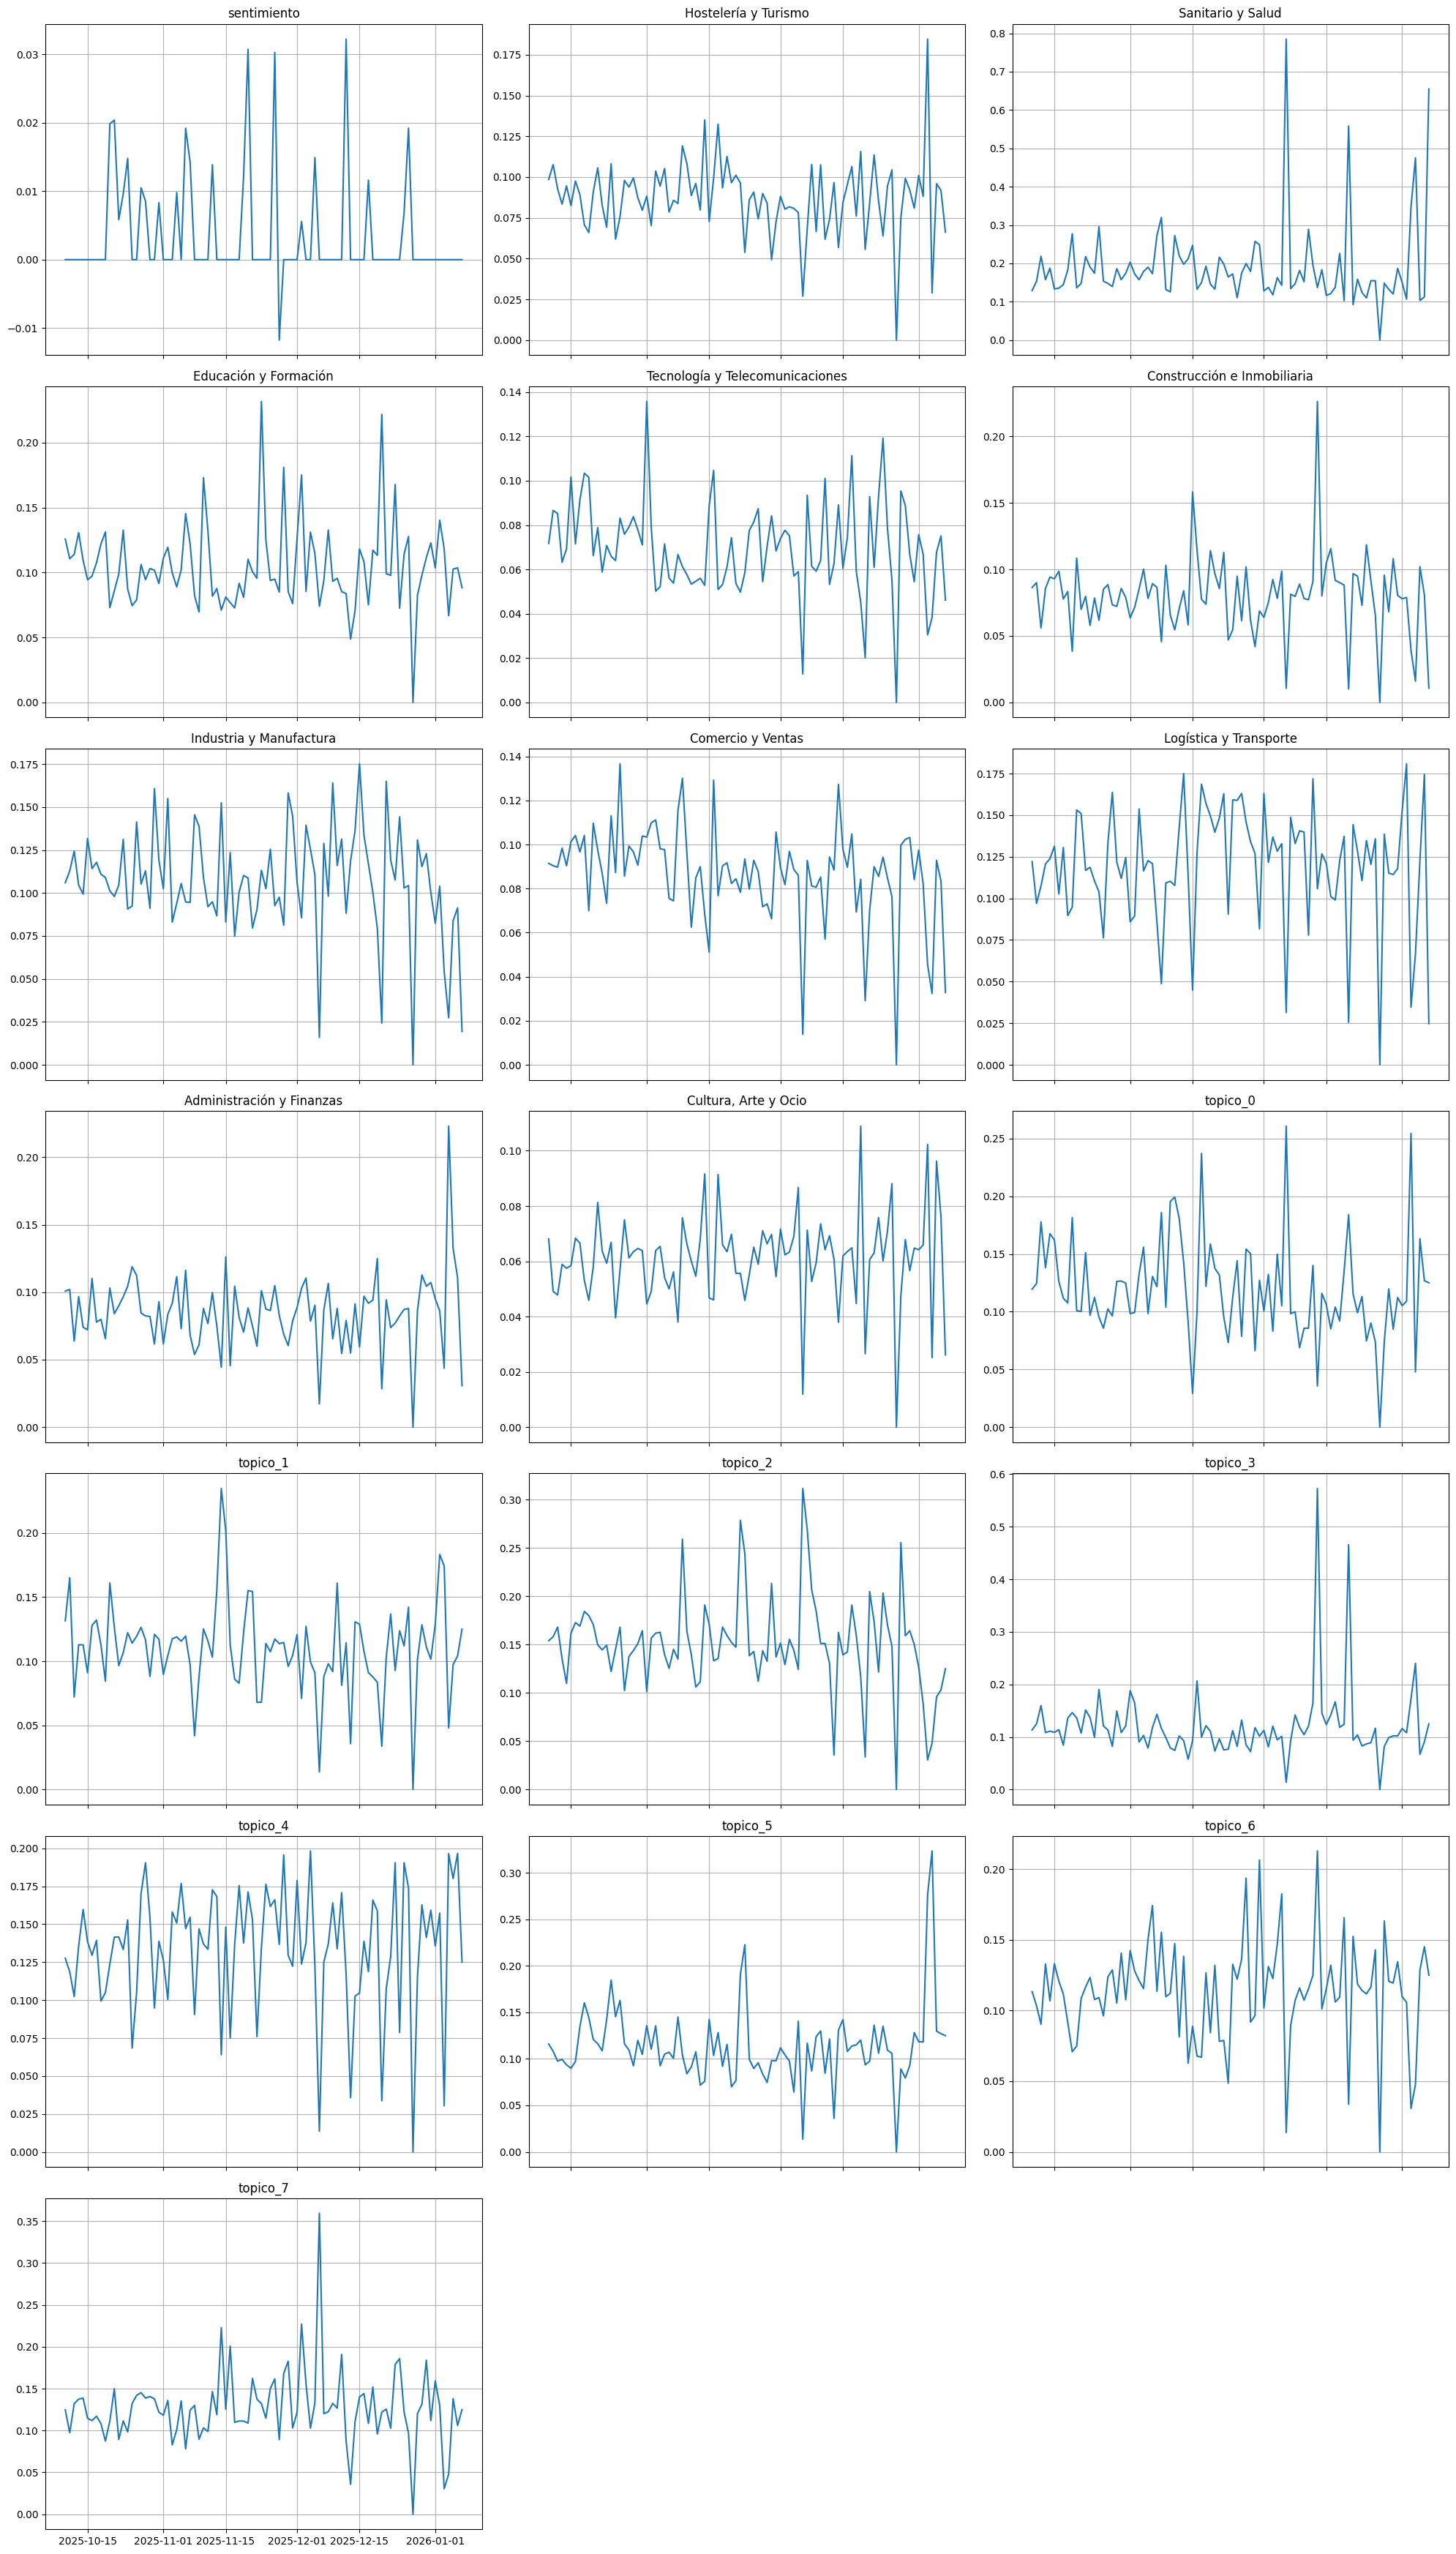

In [51]:
columnas_excluir = ["provincia", "titulo", "id", "timestamp"]
indicadores = [col for col in df.columns if col not in columnas_excluir]

# 3. Configurar subplots: 3 por fila
n_cols = 3
n_rows = int(np.ceil(len(indicadores) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), sharex=True)
axes = axes.flatten()

# 4. Graficar cada indicador en su subplot
for i, indicador in enumerate(indicadores):
    series_diaria = agrupar(df, indicador, freq="D")
    axes[i].plot(series_diaria.index, series_diaria.values)
    axes[i].set_title(indicador)
    axes[i].grid(True)

# 5. Eliminar subplots vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

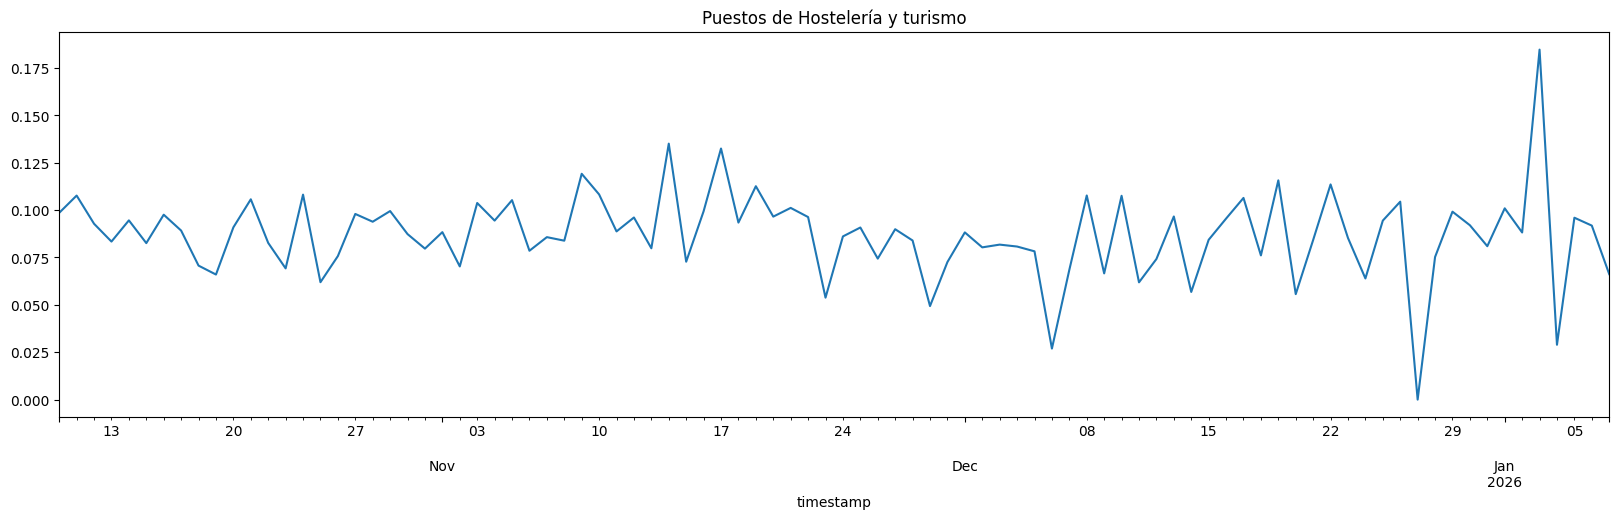

timestamp
2025-10-10    0.098553
2025-10-11    0.107654
2025-10-12    0.092778
2025-10-13    0.083383
2025-10-14    0.094569
Freq: D, Name: Hostelería y Turismo, dtype: float64

In [52]:
indicador = "Hostelería y Turismo"

# 3. Agrupar por días
series_diaria = agrupar(df, indicador, freq="D")

series_diaria.plot(figsize=(20,5), title = "Puestos de Hostelería y turismo")
plt.show()
series_diaria.head()

In [53]:
pd.Series(series_diaria.index).describe()

count                     90
mean     2025-11-23 12:00:00
min      2025-10-10 00:00:00
25%      2025-11-01 06:00:00
50%      2025-11-23 12:00:00
75%      2025-12-15 18:00:00
max      2026-01-07 00:00:00
Name: timestamp, dtype: object

In [54]:
series_diaria.isna().sum()

0

In [55]:
# 4. Test de estacionariedad (ADF)
print("Test ADF sobre la serie:")
adfuller(series_diaria)

Test ADF sobre la serie:


(-10.830291822911487,
 1.7149869671590894e-19,
 0,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 -351.20688871680045)

Test ADF sobre la random walk:


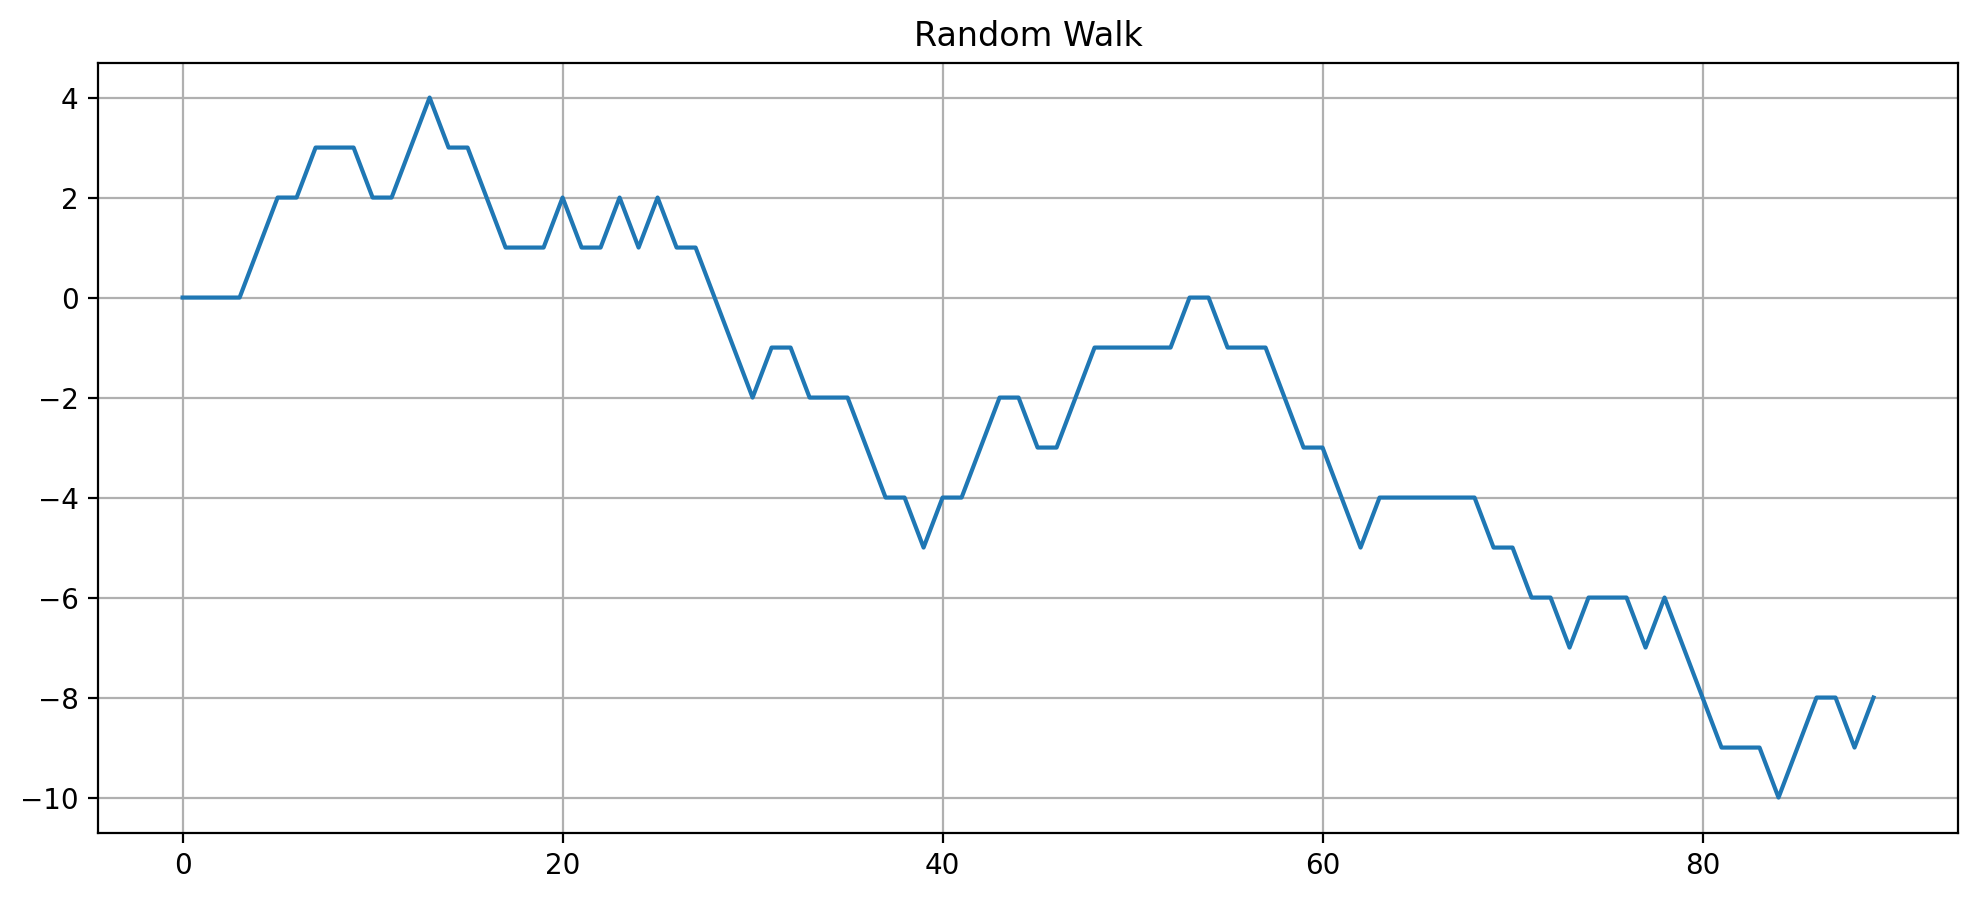

(-0.4323470242763175,
 0.9045562850429202,
 0,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 177.08215046642547)

In [56]:
print("Test ADF sobre la random walk:")
adfuller(generar_random_walk(step_n=len(series_diaria), plot=True))

Test ADF sobre la random walk:


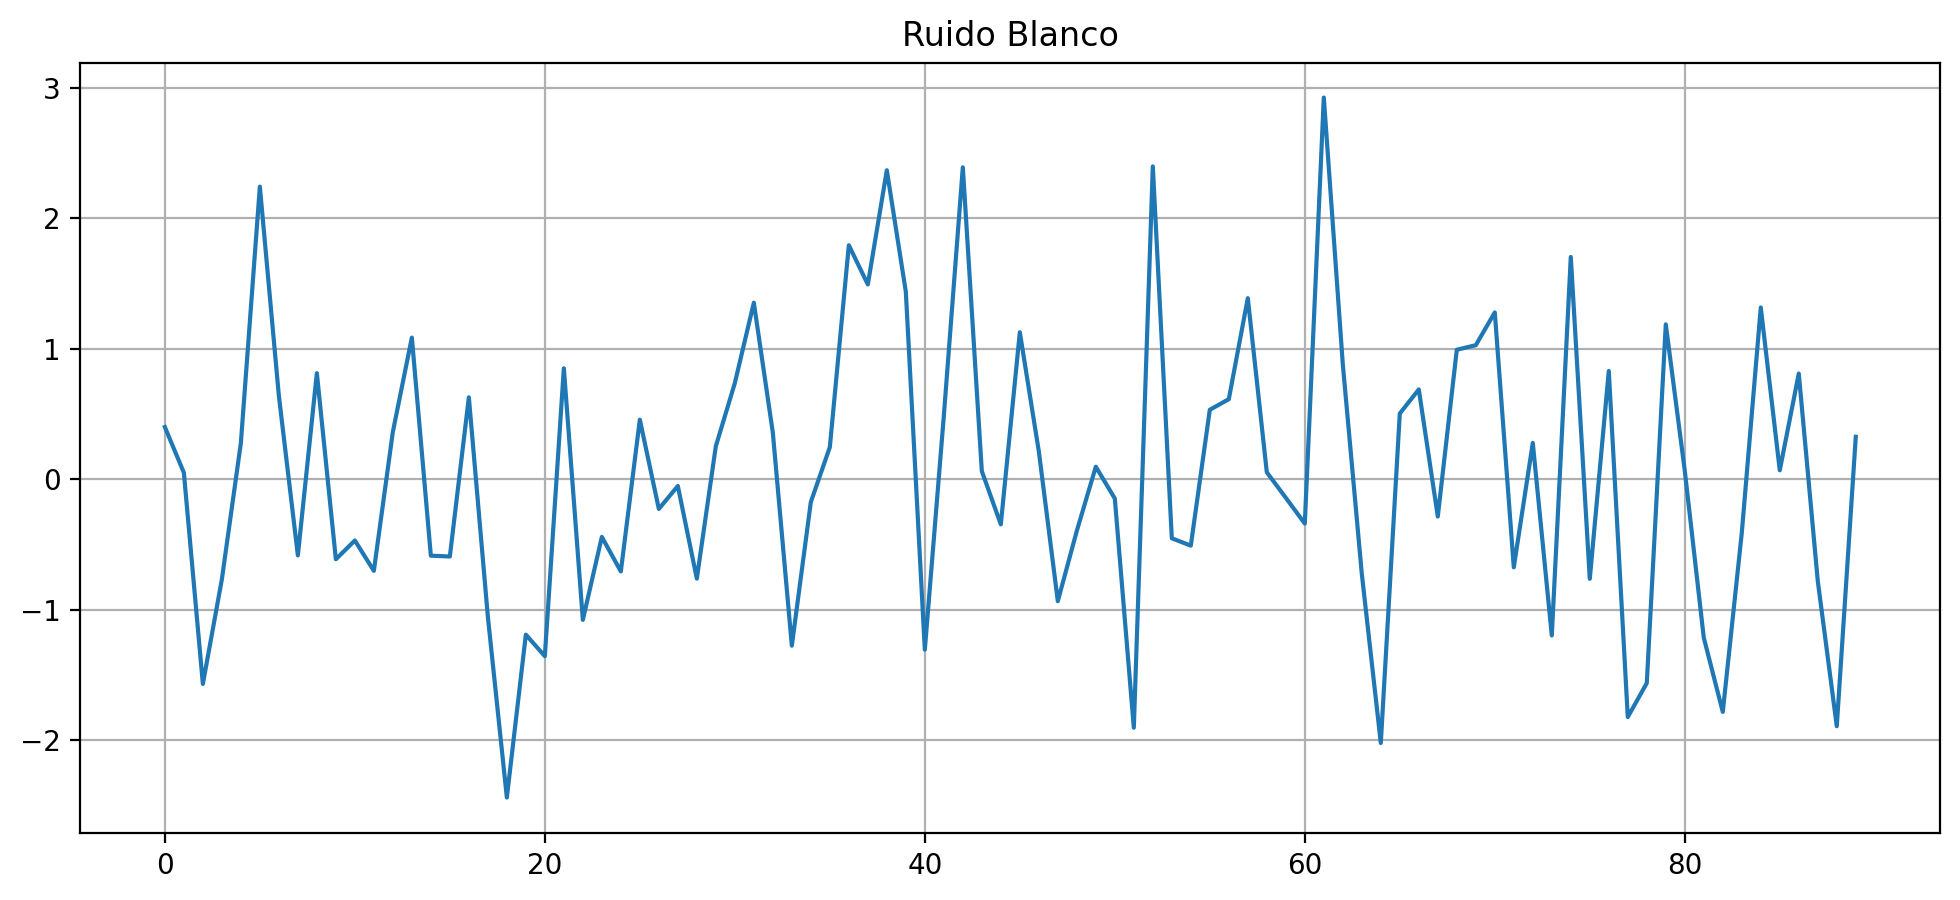

(-8.308472431843683,
 3.846013199323871e-13,
 0,
 89,
 {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 241.0288354836208)

In [57]:
print("Test ADF sobre la random walk:")
adfuller(generar_ruido_blanco(n=len(series_diaria), plot=True))

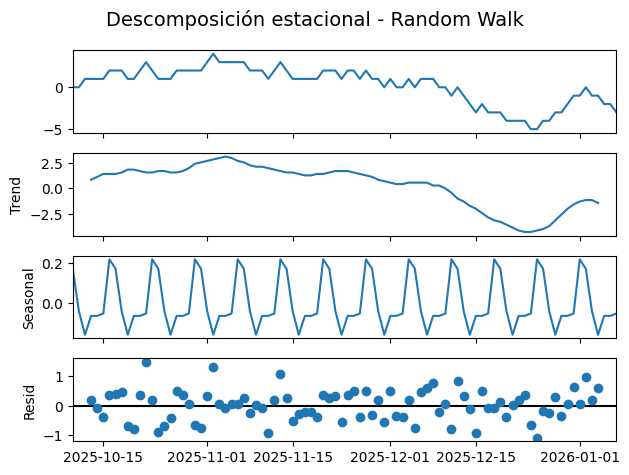

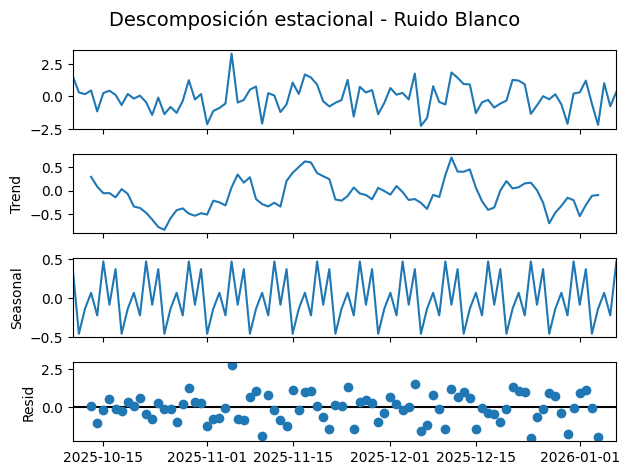

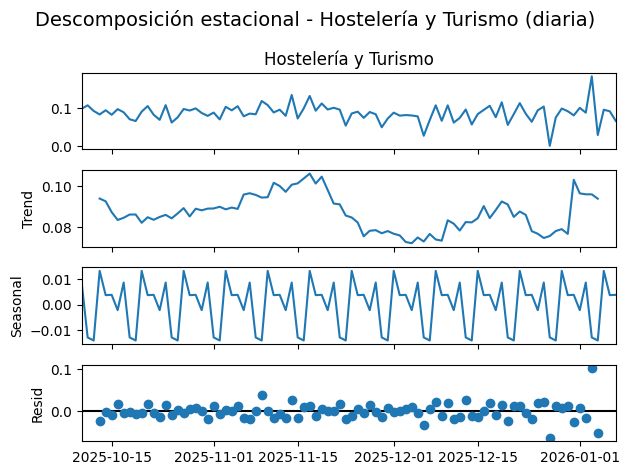

In [58]:
# Random Walk
path_rw = generar_random_walk(step_n=len(series_diaria), plot=False)
series_rw = pd.Series(path_rw, index=series_diaria.index)

# Ruido Blanco
wn = generar_ruido_blanco(n=len(series_diaria), plot=False)
series_wn = pd.Series(wn, index=series_diaria.index)


# --- Descomposición estacional Random Walk ---
result_rw = seasonal_decompose(series_rw, model="additive", period=7)
result_rw.plot()
plt.suptitle("Descomposición estacional - Random Walk", fontsize=14)
plt.tight_layout()
plt.show()

# --- Descomposición estacional Ruido Blanco ---
result_wn = seasonal_decompose(series_wn, model="additive", period=7)
result_wn.plot()
plt.suptitle("Descomposición estacional - Ruido Blanco", fontsize=14)
plt.tight_layout()
plt.show()

# --- Descomposición estacional Serie Real ---
result_real = seasonal_decompose(series_diaria, model="additive", period=7)
result_real.plot()
plt.suptitle(f"Descomposición estacional - {indicador} (diaria)", fontsize=14)
plt.tight_layout()
plt.show()


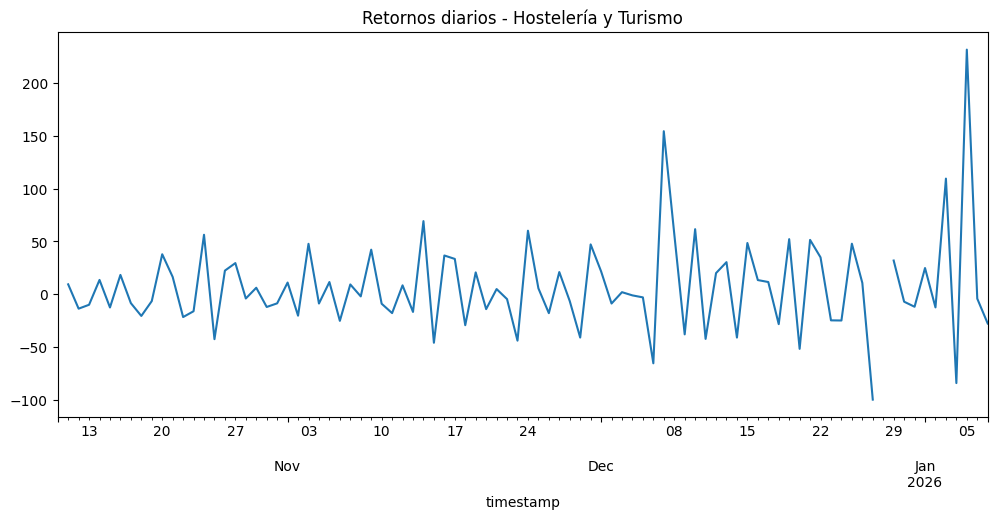

In [59]:
# 6. Retornos (variación porcentual diaria)
returns = series_diaria.pct_change(1) * 100
returns.plot(figsize=(12,5), title=f"Retornos diarios - {indicador}")
plt.show()


In [60]:
print(returns[returns.isna()])
print(returns[returns == np.inf])
returns[returns == np.inf] = 0

timestamp
2025-10-10   NaN
Freq: D, Name: Hostelería y Turismo, dtype: float64
timestamp
2025-12-28    inf
Freq: D, Name: Hostelería y Turismo, dtype: float64


In [61]:
print("Test ADF sobre retornos:")
adfuller(returns[1:])


Test ADF sobre retornos:


(-9.130243960886045,
 3.035788477839693e-15,
 1,
 87,
 {'1%': -3.5078527246648834,
  '5%': -2.895382030636155,
  '10%': -2.584823877658872},
 792.2952670768186)

/home/miguel/python3.12/lib/python3.12/site-packages/tslearn/utils/utils.py:129: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(
/home/miguel/python3.12/lib/python3.12/site-packages/tslearn/utils/utils.py:129: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(


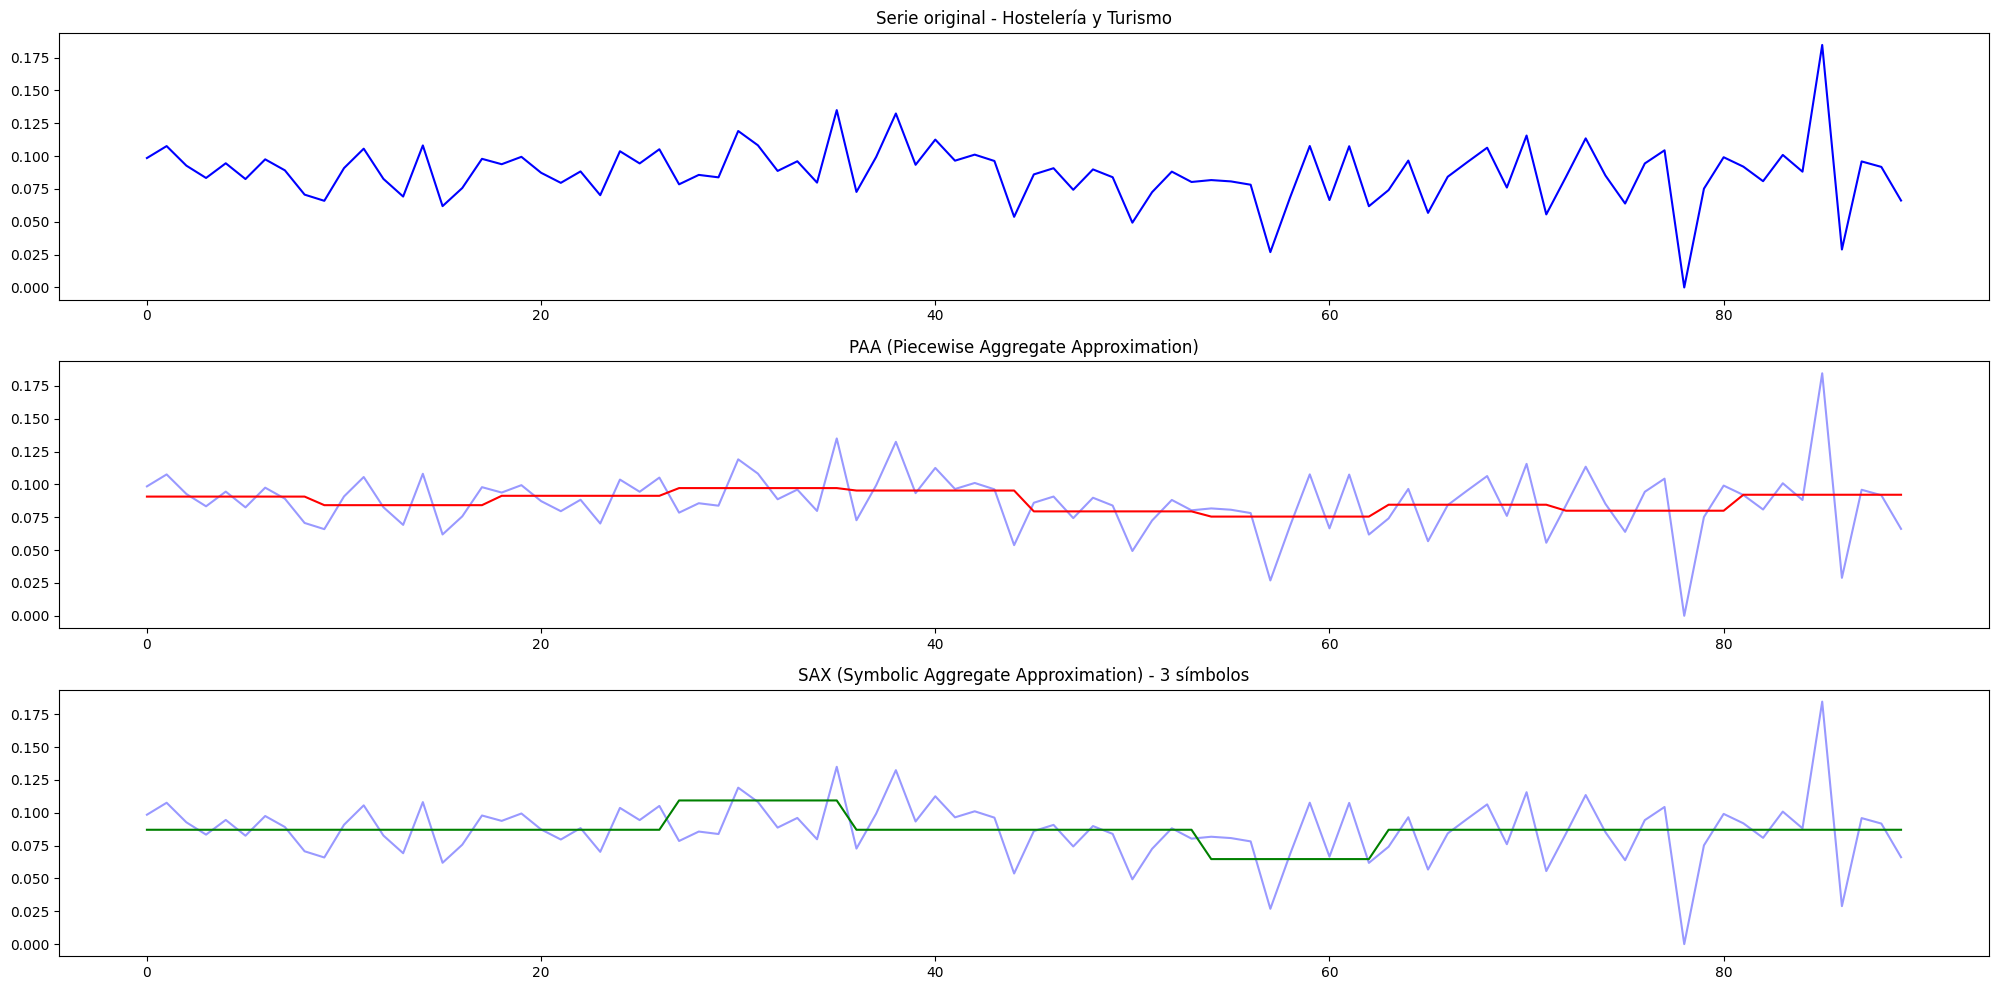

In [62]:
# 7. Reducción de complejidad con PAA y SAX
raeashape = np.array(series_diaria.tolist()).reshape(1, -1)

# PAA
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_inv = paa.inverse_transform(paa.fit_transform(raeashape))

# Normalización para SAX
data_norm = (raeashape - np.mean(raeashape)) / np.std(raeashape)

# SAX
n_sax_symbols = 3
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_inv = sax.inverse_transform(sax.fit_transform(data_norm))
sax_inv_desnorm = (sax_inv * np.std(raeashape)) + np.mean(raeashape)

# 8. Graficar original vs PAA vs SAX
plt.figure(figsize=(20,10))

plt.subplot(3, 1, 1)
plt.plot(series_diaria.values, "b-")
plt.title(f"Serie original - {indicador}")

plt.subplot(3, 1, 2)
plt.plot(series_diaria.values, "b-", alpha=0.4)
plt.plot(paa_inv[0].ravel(), "r-")
plt.title("PAA (Piecewise Aggregate Approximation)")

plt.subplot(3, 1, 3)
plt.plot(series_diaria.values, "b-", alpha=0.4)
plt.plot(sax_inv_desnorm[0].ravel(), "g-")
plt.title(f"SAX (Symbolic Aggregate Approximation) - {n_sax_symbols} símbolos")

plt.tight_layout()
plt.show()
